In [1]:
import os
import cv2
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, GlobalAvgPool2D, GlobalMaxPool2D, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.utils import plot_model

from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
INPUT_PATH = "../input/fer13-cleaned-dataset/"

In [3]:
total_images = 0
for dir_ in os.listdir(INPUT_PATH):
    count = 0
    for f in os.listdir(INPUT_PATH + dir_ + "/"):
        count += 1
        total_images += 1
    print(f"{dir_} has {count} number of images")
    
print(f"\ntotal images are {total_images}")

fear has 2535 number of images
Angry has 2832 number of images
Neutral has 4295 number of images
disgust has 380 number of images
Happy has 6834 number of images

total images are 16876


In [4]:
TOP_EMOTIONS = ["fear", "Happy", "Neutral", "Angry"]
total_images -= 380
total_images

16496

In [5]:
img_arr = np.empty(shape=(total_images,48,48,3))
img_label = np.empty(shape=(total_images))
label_to_text = {}

i = 0
e = 0
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in TOP_EMOTIONS:
        label_to_text[e] = dir_
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            img_arr[i] = cv2.imread(INPUT_PATH + dir_ + "/" + f)
            img_label[i] = e
            i += 1
        print(f"loaded all {dir_} images to numpy arrays")
        e += 1

img_arr.shape, img_label

loaded all fear images to numpy arrays
loaded all Angry images to numpy arrays
loaded all Neutral images to numpy arrays
loaded all Happy images to numpy arrays


((16496, 48, 48, 3), array([0., 0., 0., ..., 3., 3., 3.]))

In [6]:
label_to_text

{0: 'fear', 1: 'Angry', 2: 'Neutral', 3: 'Happy'}

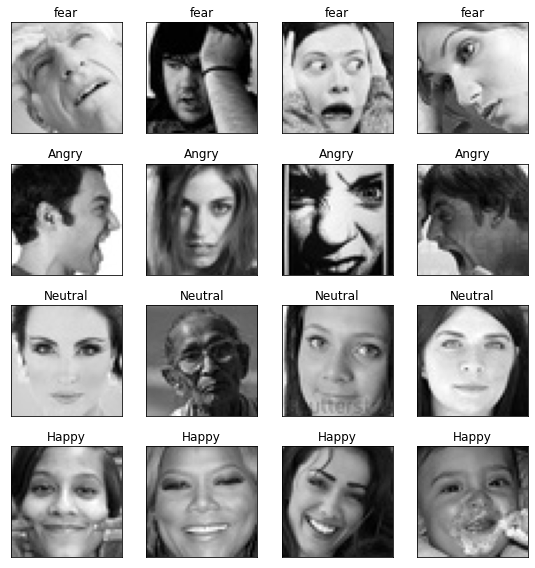

In [7]:
fig = pyplot.figure(1, (8,8))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label==k)[0], size=4, replace=False)
    sample_images = img_arr[sample_indices]
    for img in sample_images:
        idx += 1
        ax = pyplot.subplot(4,4,idx)
        ax.imshow(img[:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])
        pyplot.tight_layout()

In [8]:
img_label = np_utils.to_categorical(img_label)
img_label.shape

(16496, 4)

`Splitting the data into training and validation set.`

In [9]:
img_arr = img_arr / 255.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    train_size=0.8, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13196, 48, 48, 3), (3300, 48, 48, 3), (13196, 4), (3300, 4))

In [11]:
del img_arr
del img_label

In [12]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [13]:
# model = Sequential([
#     MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
#     GlobalAveragePooling2D(),
#     Dense(256, activation='relu', kernel_regularizer=l2(l2_reg)),  # Add L2 regularization
#     Dense(num_classes, activation='softmax')
# ])
from keras.regularizers import l2

# Define regularization strength
l2_reg = 0.0001  # Example regularization strength, you can adjust as needed

mobile_net = MobileNet(
    input_shape = (img_width, img_height, img_depth),
    include_top = False,
    weights = "imagenet",
    classes = num_classes
)

x = mobile_net.layers[-14].output
global_pool = GlobalMaxPool2D(name="global_pool")(x)
hidden_layer = Dense(256, activation='relu', kernel_regularizer=l2(l2_reg))(global_pool)
out = Dense(num_classes, activation="softmax", name="out_layer")(hidden_layer)

model = Model(inputs=mobile_net.input, outputs=out)

/opt/conda/lib/python3.6/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [14]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 49, 49, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 24, 24, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 24, 24, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 24, 24, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 24, 24, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 24, 24, 32)        128   

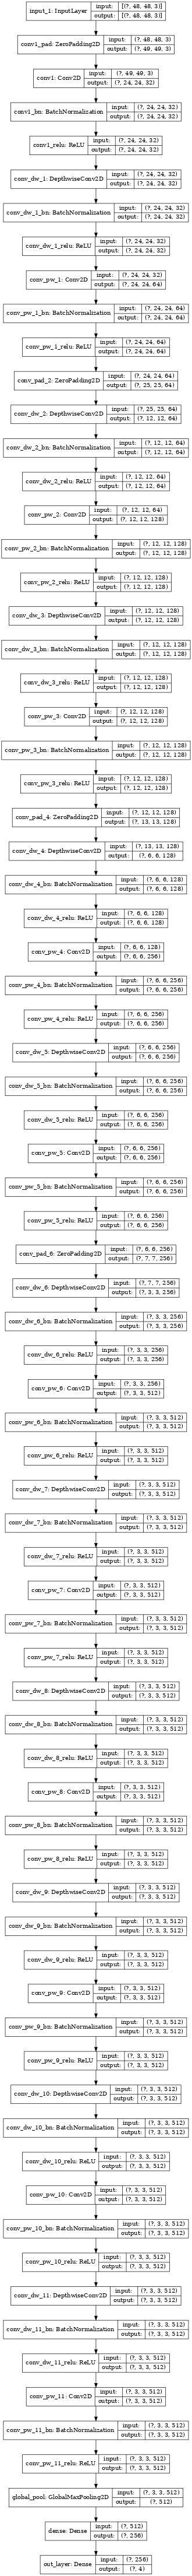

In [15]:
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50, to_file='mobilenet.png')

In [16]:
for layer in model.layers[:15]:
    layer.trainable = False

In [17]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
     brightness_range=[0.5, 1.5],  # Adjust brightness randomly
     fill_mode='nearest',  # Fill in newly created pixels
     zca_whitening=False,
)
train_datagen.fit(X_train)

In [18]:

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00008,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.25,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler
]

In [19]:
batch_size = 32
epochs = 50

# optims = [
#     optimizers.Nadam(learning_rate=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
#     optimizers.Adam(0.01),
# ]

model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizers.Adam(0.01),
        metrics=['accuracy']
)



history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Train for 412.375 steps, validate on 3300 samples
Epoch 1/50
413/412 [==============================] - 18s 44ms/step - loss: 1.5718 - accuracy: 0.4555 - val_loss: 1.0651 - val_accuracy: 0.5645
Epoch 2/50
413/412 [==============================] - 15s 36ms/step - loss: 1.0912 - accuracy: 0.5500 - val_loss: 1.0920 - val_accuracy: 0.5385
Epoch 3/50
413/412 [==============================] - 15s 36ms/step - loss: 1.0145 - accuracy: 0.5867 - val_loss: 1.1134 - val_accuracy: 0.5794
Epoch 4/50
413/412 [==============================] - 15s 35ms/step - loss: 0.9735 - accuracy: 0.6029 - val_loss: 1.6768 - val_accuracy: 0.4745
Epoch 5/50
413/412 [==============================] - 15s 36ms/step - loss: 0.9657 - accuracy: 0.6057 - val_loss: 1.0707 - val_accuracy: 0.5609
Epoch 6/50
413/412 [==============================] - 15s 36ms/step - loss: 0.9303 - accuracy: 0.6228 - val_loss: 0.9488 - val_accuracy: 0.5985
Epoch 7/50
413/412 [==============================] - 15s 36ms/step - loss: 0.9166 - a

In [20]:
model_yaml = model.to_yaml()
with open("model_mobelnet.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("model_moblenet.h5")

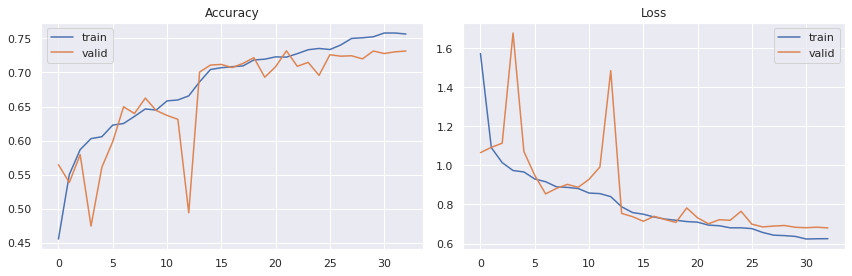

In [21]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_mobilenet.png')
pyplot.show()

In [22]:
label_to_text

{0: 'fear', 1: 'Angry', 2: 'Neutral', 3: 'Happy'}

In [23]:
text_to_label = dict((v,k) for k,v in label_to_text.items())
text_to_label

{'fear': 0, 'Angry': 1, 'Neutral': 2, 'Happy': 3}

test accuracy: 73.1818 %


              precision    recall  f1-score   support

           0       0.69      0.41      0.52       507
           1       0.67      0.50      0.58       567
           2       0.61      0.80      0.69       859
           3       0.86      0.90      0.88      1367

    accuracy                           0.73      3300
   macro avg       0.71      0.65      0.67      3300
weighted avg       0.73      0.73      0.72      3300



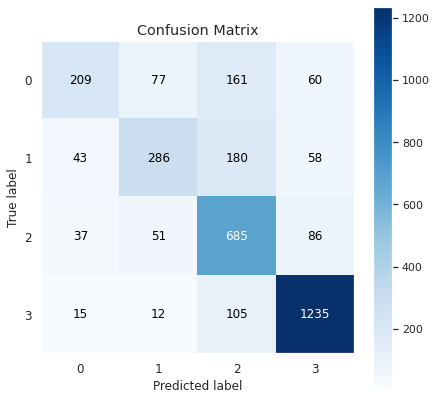

In [24]:
yhat_test = np.argmax(model.predict(X_test), axis=1)
ytest_ = np.argmax(y_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))
pyplot.savefig("confusion_matrix_mobilenet.png")

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(classification_report(ytest_, yhat_test))

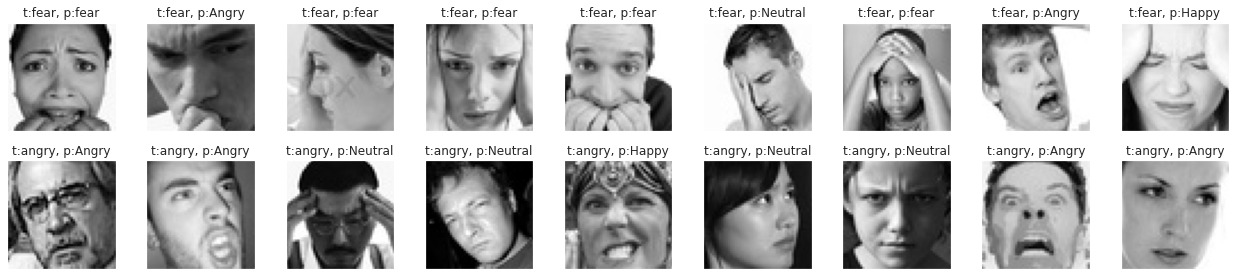

In [25]:
np.random.seed(42)
fear_imgs = np.random.choice(np.where(y_test[:, text_to_label["fear"]]==1)[0], size=9, replace=False)
angry_imgs = np.random.choice(np.where(y_test[:, text_to_label["Angry"]]==1)[0], size=9, replace=False)

fig = pyplot.figure(1, (18, 4))

for i, (fear_idx, angry_idx) in enumerate(zip(fear_imgs, angry_imgs)):
        sample_img = X_test[fear_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = pyplot.subplot(2, 9, i+1)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:fear, p:{pred}")

        sample_img = X_test[angry_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = pyplot.subplot(2, 9, i+10)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:angry, p:{pred}")

        pyplot.tight_layout()

In [26]:
def plot_miss_classified(emotion):
    miss_happy_indices = np.where((ytest_ != yhat_test) & (ytest_==text_to_label[emotion]))[0]
    print(f"total {len(miss_happy_indices)} miss labels out of {len(np.where(ytest_==text_to_label[emotion])[0])} for emotion {emotion}")

    cols = 15
    rows = math.ceil(len(miss_happy_indices) / cols)
    fig = pyplot.figure(1, (20, rows * 2))

    for i,idx in enumerate(miss_happy_indices):
        sample_img = X_test[idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = pyplot.subplot(rows,cols,i+1)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"p:{pred}")    

total 132 miss labels out of 1367 for emotion Happy


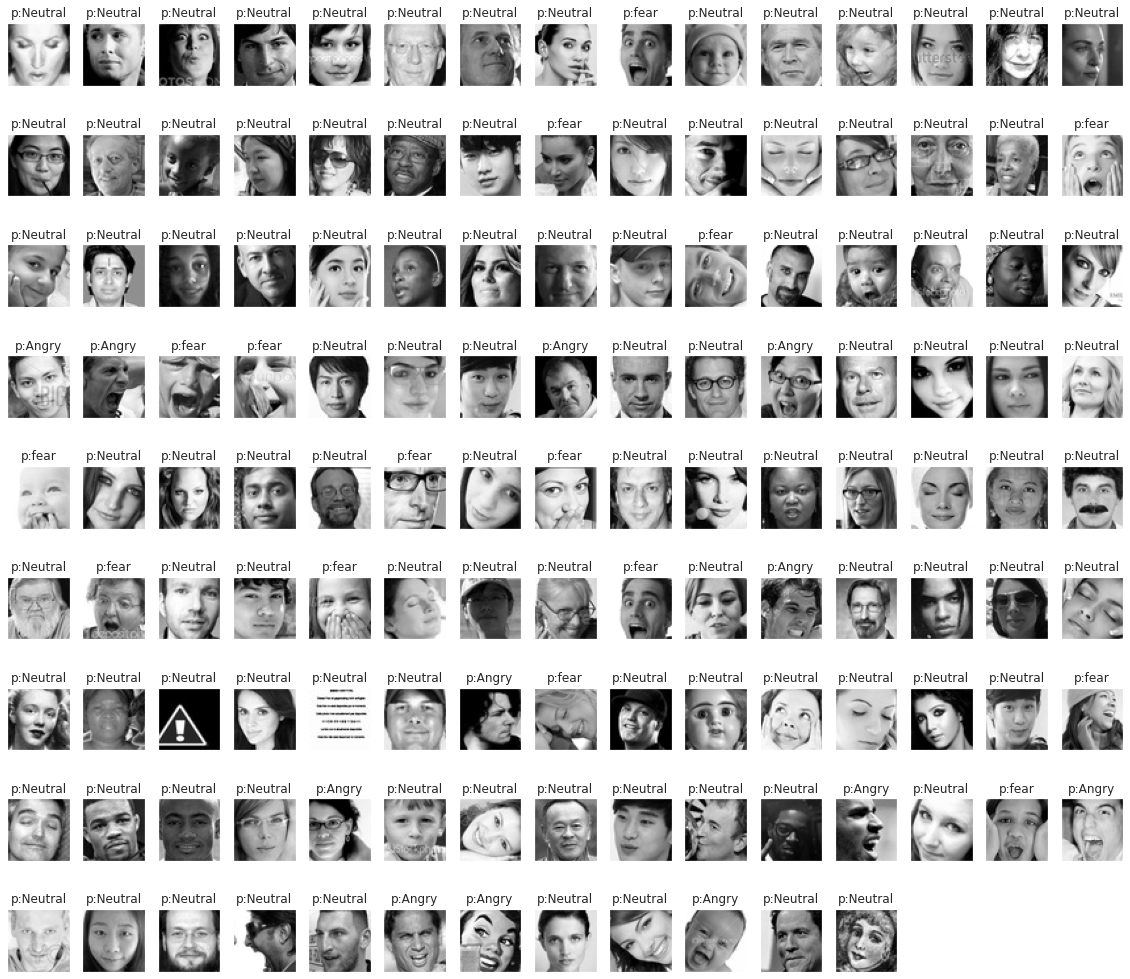

In [27]:
plot_miss_classified(emotion="Happy")

total 298 miss labels out of 507 for emotion fear


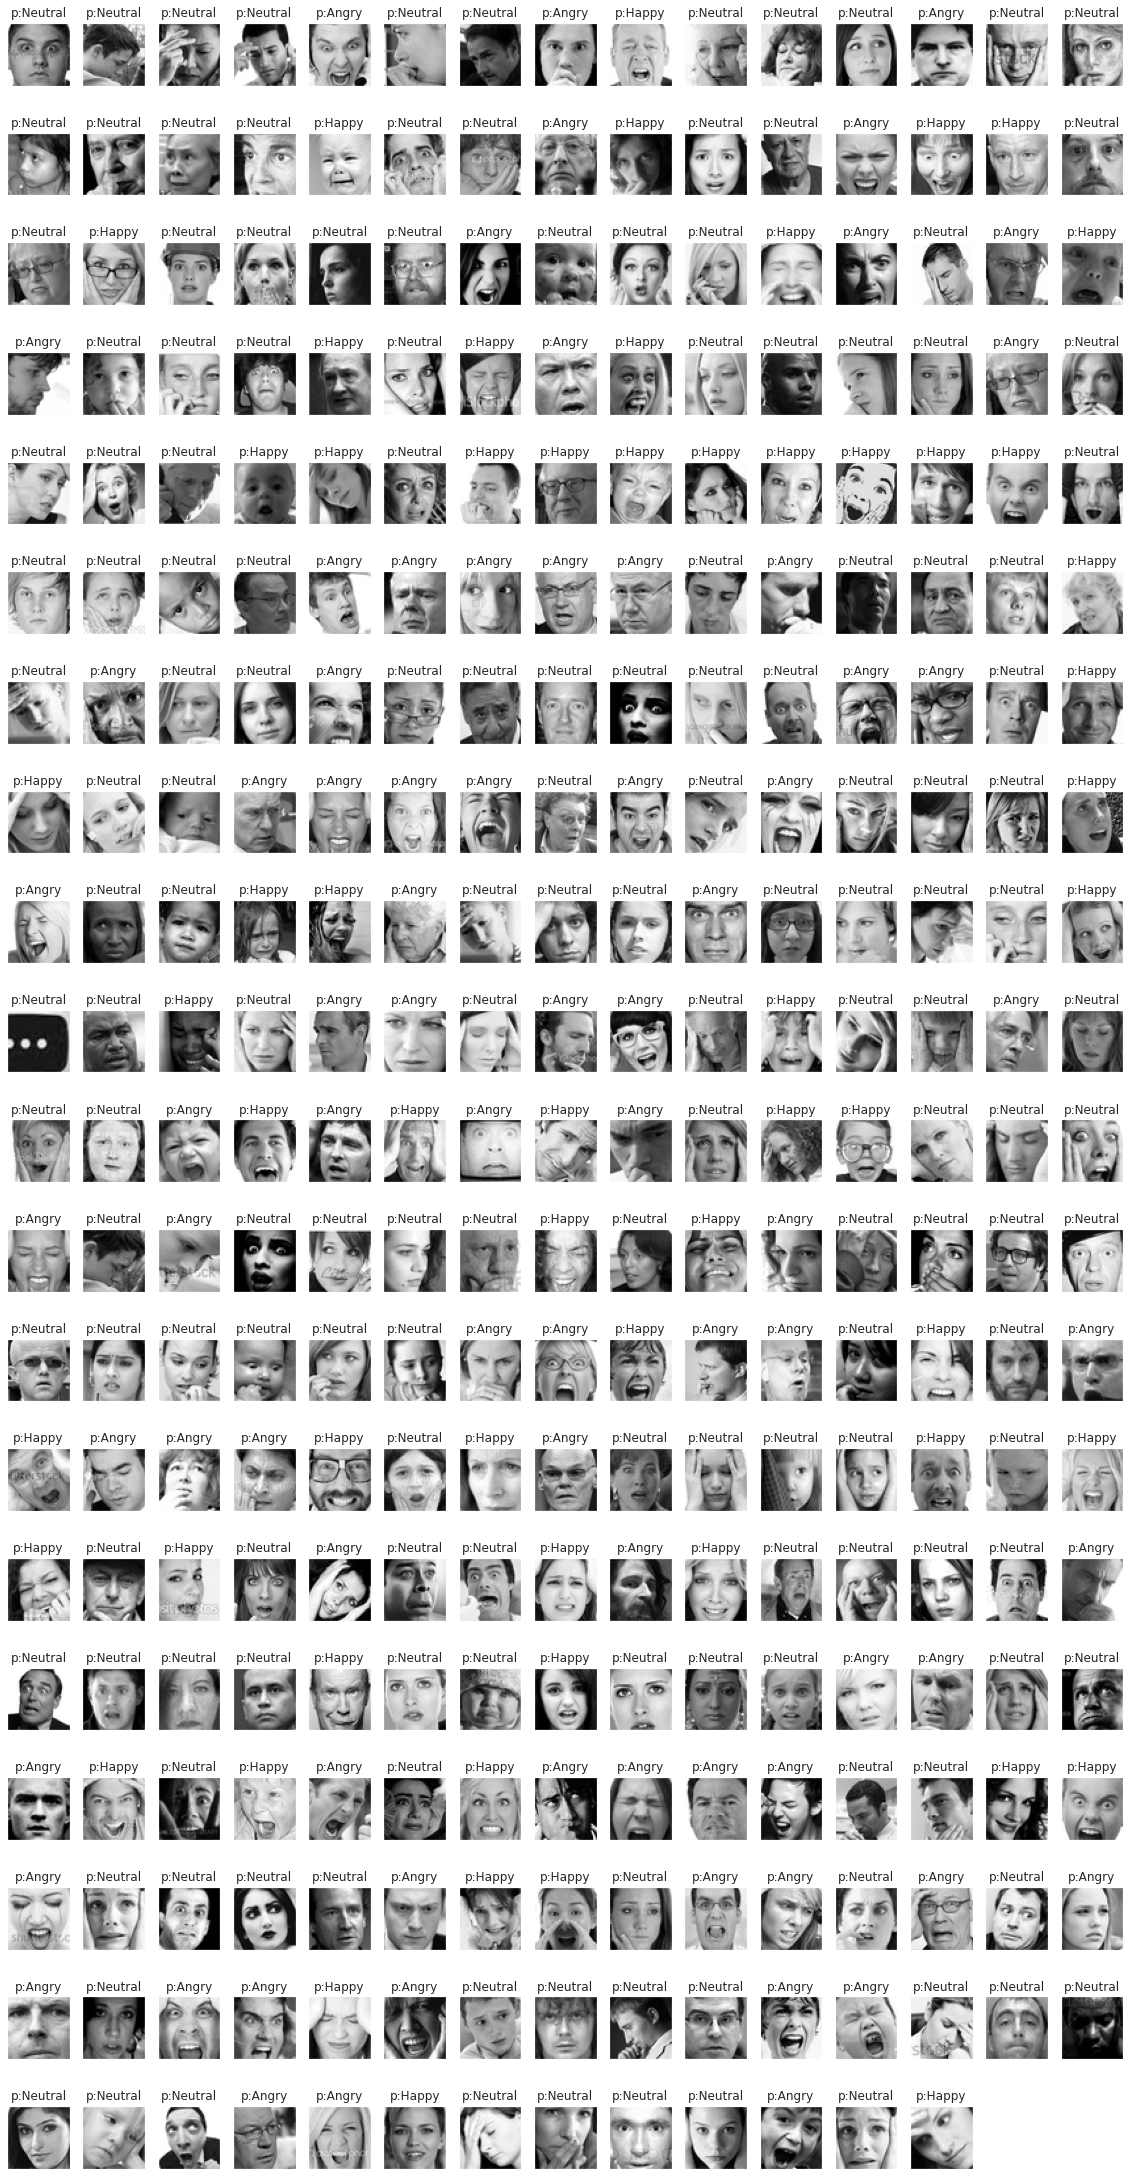

In [28]:
plot_miss_classified(emotion="fear")

total 281 miss labels out of 567 for emotion Angry


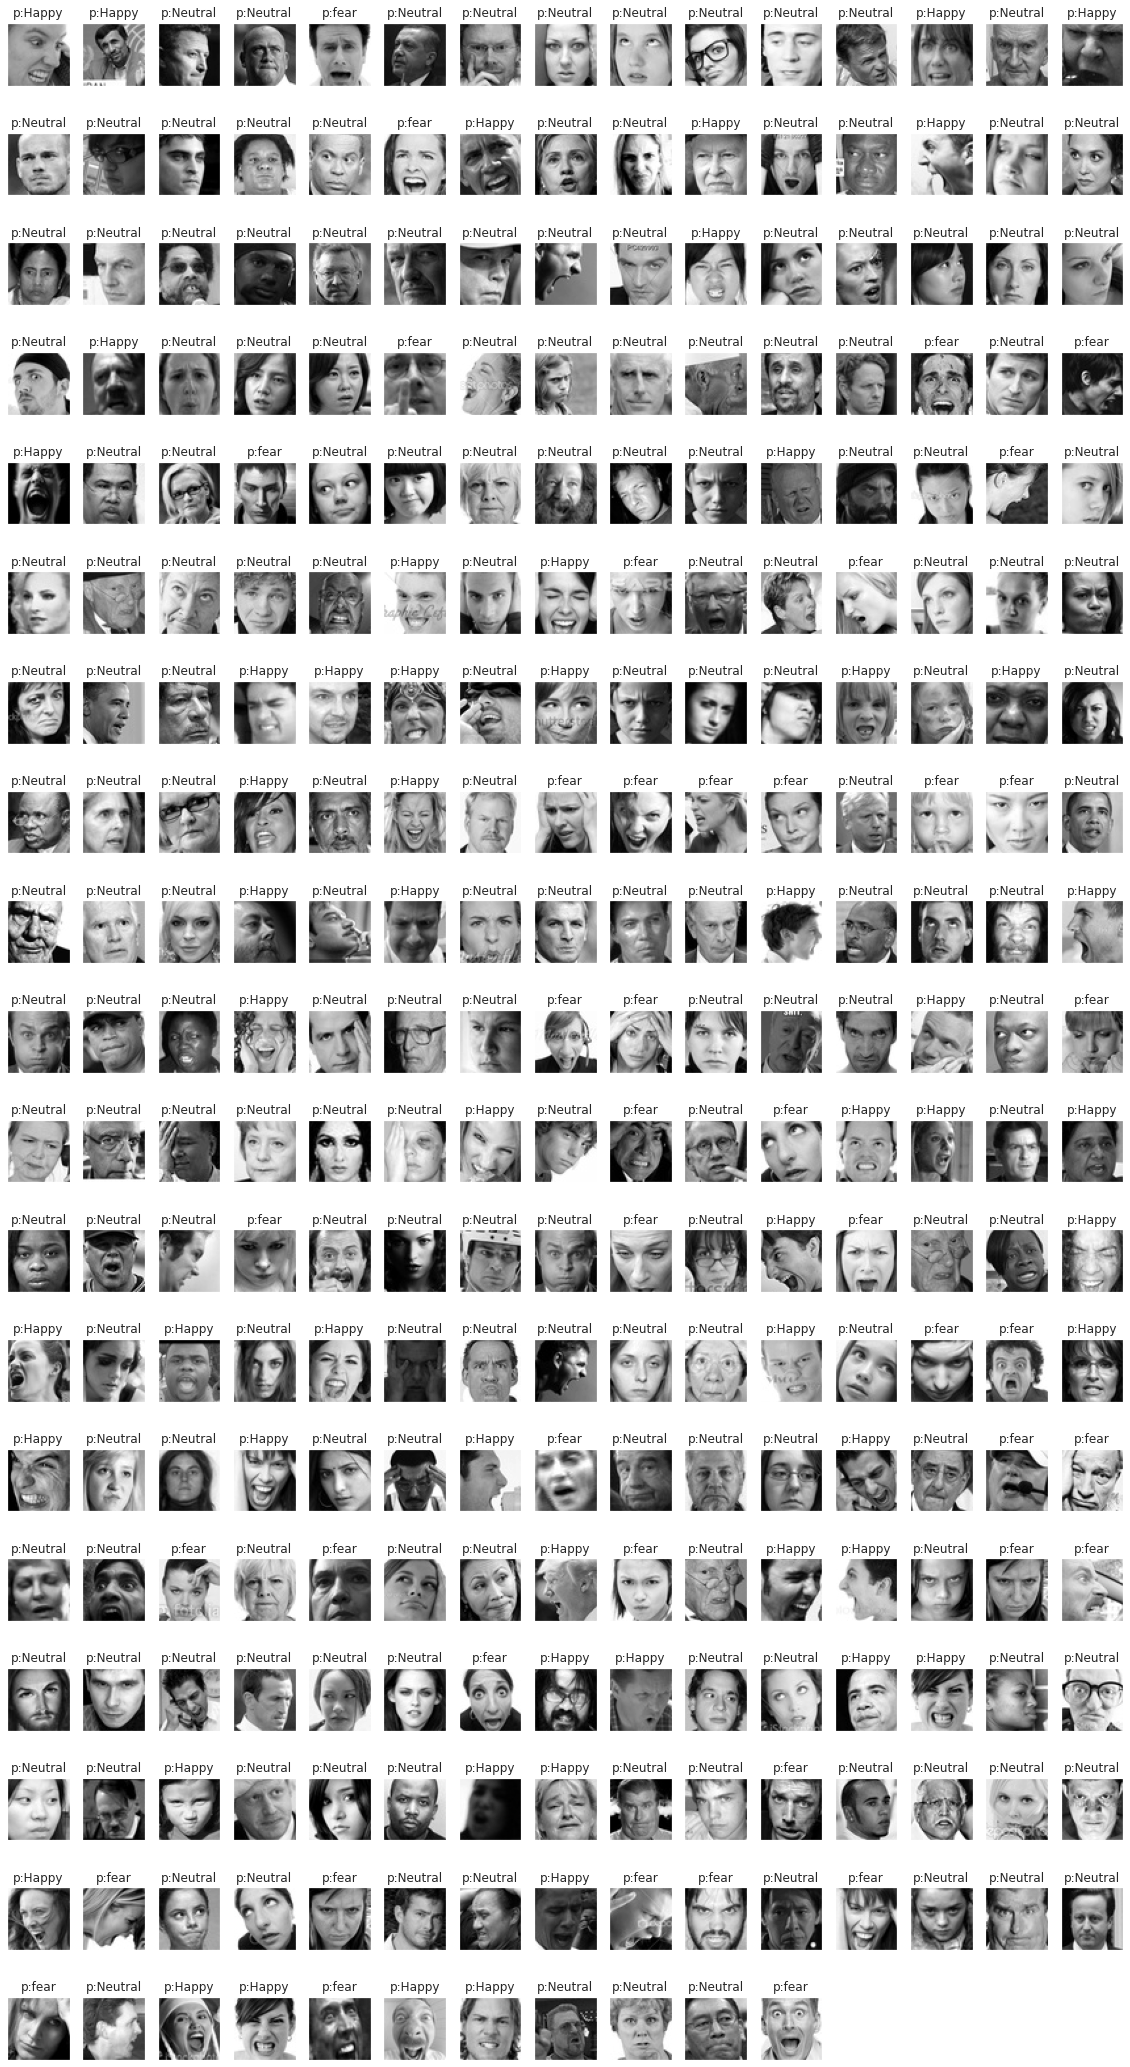

In [29]:
plot_miss_classified(emotion="Angry")

total 174 miss labels out of 859 for emotion Neutral


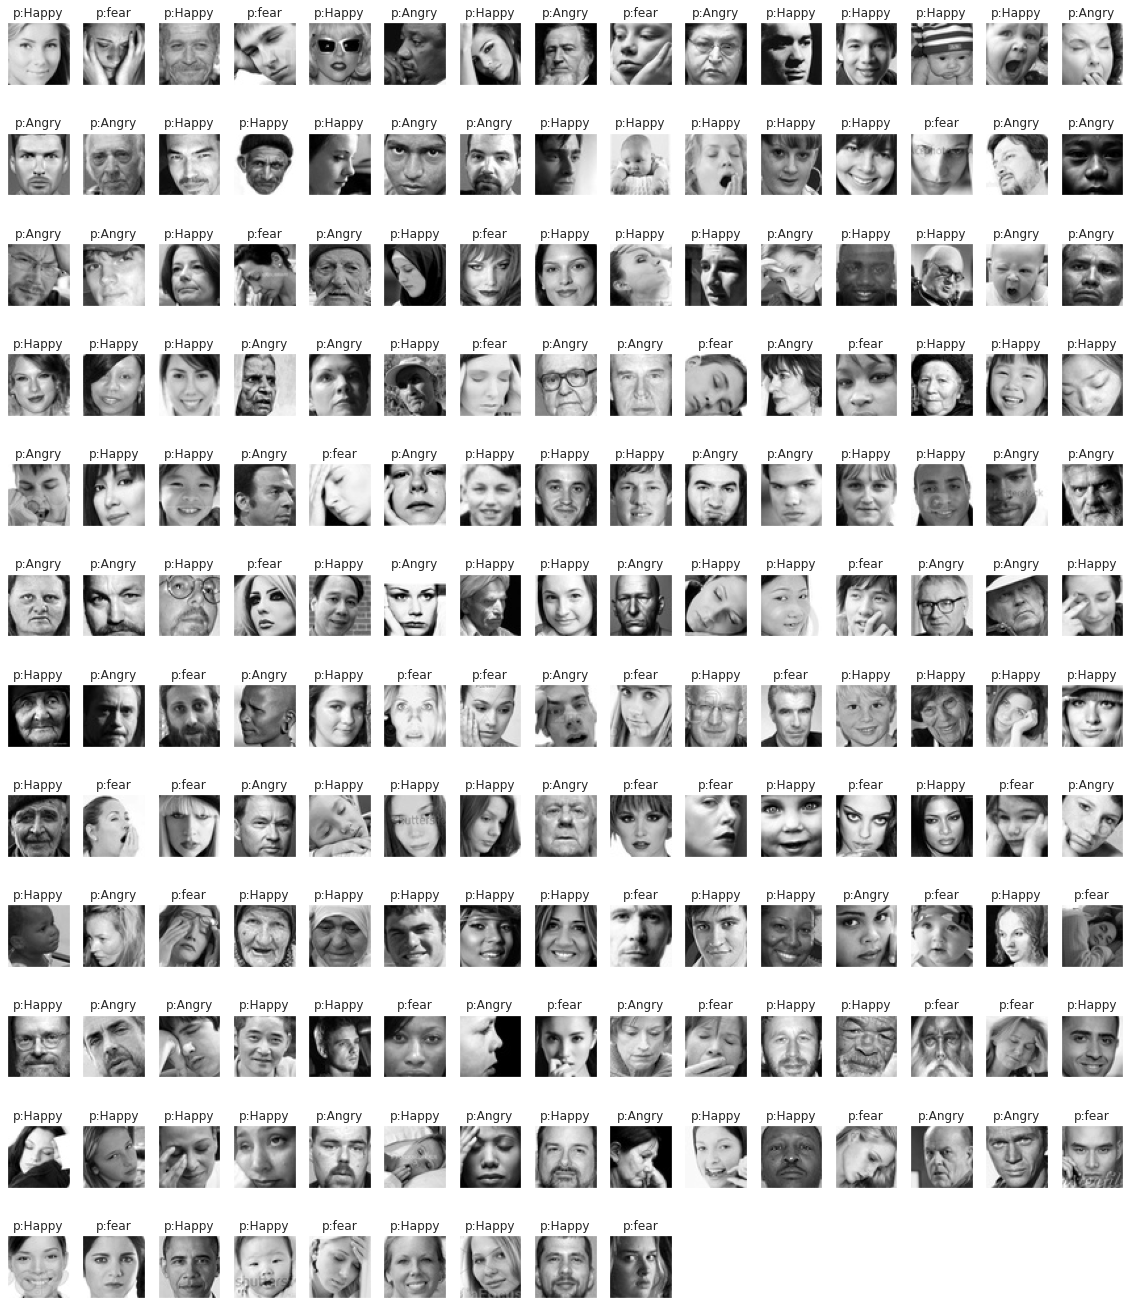

In [30]:
plot_miss_classified(emotion="Neutral")